# Problem Description

Netflix is looking to improve their movie and tv show recommendation system. They would like your expertise on their current prioritiy which is growing their user base based on their movie selection. As such, they have provided movie metadata containing a sample of their movie inventory along with information gathered that display for each movie the cast, ratings, genre, and other helpful information that they think would be helpful in this implementation. Furthermore, Netflix would like a way to suggest to users movie that they think users would like based on genre's they're interested in, and how other users have already rated the movies. In essence, displaying for example the top ten movies as a suggestion to users would be the goal. It's vital that these top ten recommendations are useful and have a high likelihood the user would be interested because Netflix has seen a pattern of this recommendation system retaining and attracting new users to their platform, which directly impacts their business profit and growth.

The type of algorithm should be collaborative filtering and/or SVD. This is an unsupervised learning task to build a movie recommendation system to users.

The dataset is sourced from Kaggle. The data itself and additional info can be found at the movie dataset located here https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset . The data is in tabular form with the movies metadata set having 45466 rows and 24 columns. 

# Exploratory Data Analysis (EDA)

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from ast import literal_eval

In [3]:
mv = pd.read_csv('movies_metadata.csv')
mv.head()

/tmp/ipykernel_438750/161917937.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  mv = pd.read_csv('movies_metadata.csv')


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


This movie metadata dataset needs to have EDA performed because numnerous features are in object form such as genres, which make it challenging to extract meaningful feature data. For example, with genres we would expect having an actua list of genres rather than a dictionary of ids and names instead of the genre value itself. 

In [4]:
mv.shape

(45466, 24)

In [5]:
mv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

As we can see here, there are a mixture of at least 5 float numeric features, a few string value features, and the rest categorical (and some features take feature engineering to make into a clear categorical feature).

In [6]:
mv.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


In [7]:
mv.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

Here we can see that several text features are filled with thousands of NaN values and we will have to be careful when using these to predict movies because some algorithms do not function well with null rows of data.

In [8]:
credits = pd.read_csv('credits.csv')
keys = pd.read_csv('keywords.csv')

In [9]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


It is clear that the credits dataset needs to have some EDA performed because the cast and crew columns are object features, which make it unclear how to be used in a meaningful way. Feature engineering will help with this.

In [10]:
keys.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [11]:
mv['genres'] = mv['genres'].apply(literal_eval).apply(lambda x: [d['name'] for d in x])
mv['genres']

0         [Animation, Comedy, Family]
1        [Adventure, Fantasy, Family]
2                   [Romance, Comedy]
3            [Comedy, Drama, Romance]
4                            [Comedy]
                     ...             
45461                 [Drama, Family]
45462                         [Drama]
45463       [Action, Drama, Thriller]
45464                              []
45465                              []
Name: genres, Length: 45466, dtype: object

## Creating a new year feature

In [12]:
mv['year'] = pd.to_datetime(mv['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [13]:
mv.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995


In [14]:
exp = mv.explode('genres')
ord_list = exp['genres'].value_counts().index

/home/henry/movie-recommender-system-svd/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/henry/movie-recommender-system-svd/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Numbers of movies by genre')

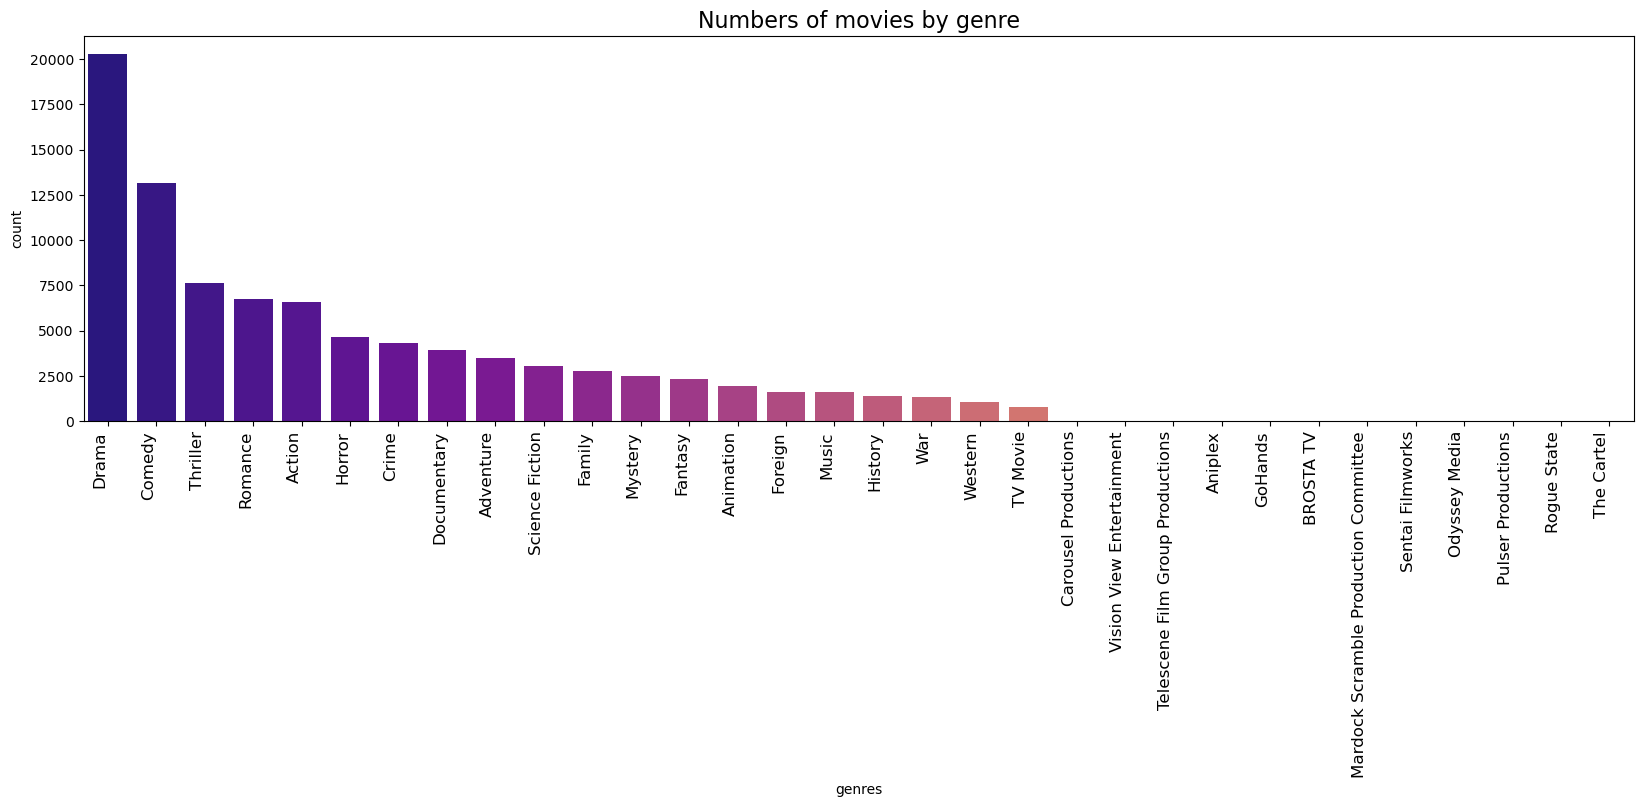

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plot = sns.countplot(x='genres', data=exp, order=ord_list, palette='plasma')
plot.set_xticklabels(plot.get_xticklabels(), fontsize=12, rotation=90, horizontalalignment='right')
plt.title('Numbers of movies by genre', fontsize=16)

In [26]:
mv = mv.dropna(subset=['title'])

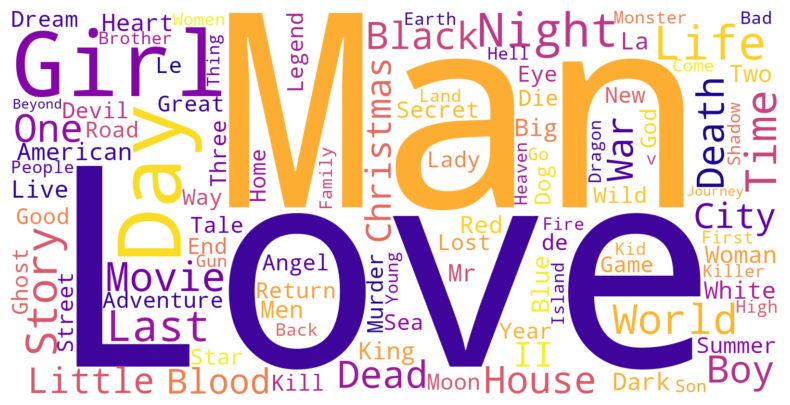

In [27]:
from wordcloud import WordCloud
text_title = ' '.join(mv['title'])
wordcloud = WordCloud(background_color='white', width=800, height=400, max_words=100, scale=2.0, colormap='plasma').generate(text_title)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [14]:
lk = pd.read_csv('links_small.csv')
lk = lk[lk['tmdbId'].notnull()]['tmdbId'].astype('int')

In [15]:
mv = mv.drop([29503, 19730, 35587])
mv['id'] = mv['id'].astype('int')
df = mv[mv['id'].isin(lk)]
df.shape

(9099, 25)

In [16]:
credits['id'] = credits['id'].astype('int')
keys['id'] = keys['id'].astype('int')

In [17]:
df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995


In [18]:
# fill features that have large na's so that we don't drop large amounts of rows that may have meaningful vote and popularity data
df['tagline'] = df['tagline'].fillna('')
df['desc'] = df['tagline'] + " " + df['overview']
df['desc'] = df['desc'].fillna('')
df.head()

/tmp/ipykernel_292715/1810792674.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tagline'] = df['tagline'].fillna('')
/tmp/ipykernel_292715/1810792674.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['desc'] = df['tagline'] + " " + df['overview']
/tmp/ipykernel_292715/1810792674.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,desc
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.7,5415.0,1995,"Led by Woody, Andy's toys live happily in his..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,Roll the dice and unleash the excitement! When...
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,Still Yelling. Still Fighting. Still Ready for...
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,Friends are the people who let you be yourself...
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,Just When His World Is Back To Normal... He's ...


In [19]:
df = df.dropna()
df.shape

(503, 26)

# Analysis (Model Building and Training)

The movie overviews and titles are not quantitative features. We do however have a way that we can use these features to improve our model performance in a qualitative way, and here I will try to build a recommender using these string value features.

In [20]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0.0, stop_words='english')
tfidf_mat = tf.fit_transform(df['desc'])
tfidf_mat.shape

(503, 21055)

I want to create a numeric value that captures the similarity between any two given movies. There are a few ways I can do this including using Cosine similarity, and since I have the TFIDF vectorizer computed above, I can use the dot product to produce the cosine simlarity score.

In [21]:
cosim = linear_kernel(tfidf_mat, tfidf_mat)
cosim

array([[1.        , 0.        , 0.        , ..., 0.00890564, 0.        ,
        0.00472681],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.01442842,
        0.        ],
       ...,
       [0.00890564, 0.        , 0.        , ..., 1.        , 0.        ,
        0.00208054],
       [0.        , 0.        , 0.01442842, ..., 0.        , 1.        ,
        0.07510919],
       [0.00472681, 0.        , 0.        , ..., 0.00208054, 0.07510919,
        1.        ]])

In [22]:
cosim[0]

array([1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01057267, 0.00678656, 0.01066355,
       0.        , 0.        , 0.        , 0.        , 0.00785986,
       0.        , 0.00946662, 0.01684039, 0.        , 0.        ,
       0.        , 0.01520849, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01201613, 0.00638159, 0.        ,
       0.        , 0.        , 0.        , 0.01258017, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00959355, 0.        , 0.01098068,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01175293, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0216396 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0091121 , 0.     

We can now experiment with implementing a function that returns the 25 most similar movies based on the cosine similarity score.

In [23]:
df = df.reset_index()
titles = df['title']
indices = pd.Series(df.index, index=df['title'])

In [24]:
def get_cosim_recommendations(title):
    i = indices[title]
    sims = list(enumerate(cosim[i]))
    ssims = sorted(sims, key=lambda s: s[1], reverse=True)
    ssims = ssims[1:26]
    return titles.iloc[[t[0] for t in ssims]]

In [25]:
get_cosim_recommendations('The Dark Knight').head(10)

367                 The Dark Knight Rises
369    Sherlock Holmes: A Game of Shadows
168                         Batman Begins
483    Batman v Superman: Dawn of Justice
413                       Despicable Me 2
43                    Tomorrow Never Dies
113                              Blade II
320       Wall Street: Money Never Sleeps
125                               Brother
449          Sin City: A Dame to Kill For
Name: title, dtype: object

In [26]:
get_cosim_recommendations('Toy Story').head(10)

78                                  Toy Story 2
308                                 Toy Story 3
107    Harry Potter and the Philosopher's Stone
106                              Monsters, Inc.
143                         You Only Live Twice
66                                 Ghostbusters
257                                    Twilight
140                                     Hellboy
76                         Bride of Re-Animator
353                                       Gantz
Name: title, dtype: object

We see that the recommendations are good at a high-level, capturing similar movies based on title. For example, with The Dark Knight, the recommendation system is able to suggest other Batman movies. However, it's unable to capture other movies that are in a similar genre, perhaps other superhero movies like Spiderman. There are other features such as cast, meaning actors or actresses, that are usually important for the popularity of a movie and what folks are interested in watching. Next, I am going to try to improve on this by taking more features in building this recommendation system such as cast and genre.

In [27]:
mv.shape

(45463, 25)

In [28]:
mv = mv.merge(credits, on='id')
mv.shape

(45538, 27)

In [29]:
mv = mv.merge(keys, on='id')
mv.shape

(46628, 28)

In [90]:
df2 = mv[mv['id'].isin(lk)]
df2.shape

(9219, 28)

In df2, I have merged the additional features I wanted into one pandas dataframe. This now includes cast, crew, genres, and credits. I will further enhance this by looking at the movie director and the top cast such as the leading actors and actresses.

In [91]:
df2.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [92]:
def retrieve_director(creditDict):
    for d in creditDict:
        if d['job'] == 'Director':
            return d['name']
    return None

In [93]:
df2['crew'] = df2['crew'].apply(literal_eval)
df2['cast'] = df2['cast'].apply(literal_eval)
df2['keywords'] = df2['keywords'].apply(literal_eval)

/tmp/ipykernel_292715/2853953165.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['crew'] = df2['crew'].apply(literal_eval)
/tmp/ipykernel_292715/2853953165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['cast'] = df2['cast'].apply(literal_eval)
/tmp/ipykernel_292715/2853953165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [94]:
df2['director'] = df2['crew'].apply(retrieve_director)
df2.head()

/tmp/ipykernel_292715/2753864197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['director'] = df2['crew'].apply(retrieve_director)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,NaN,Toy Story,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",John Lasseter
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",Joe Johnston
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",Howard Deutch
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...",Forest Whitaker
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",Charles Shyer


In [95]:
df2 = df2.drop(['crew'],axis=1)
df2.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,year,cast,keywords,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",John Lasseter
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",Joe Johnston
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",Howard Deutch
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'id': 818, 'name': 'based on novel'}, {'id':...",Forest Whitaker
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",Charles Shyer


In [96]:
df2['cast'] = df2['cast'].apply(lambda x: [c['name'] for c in x] if isinstance(x, list) else [])
df2.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,year,cast,keywords,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,1995,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",John Lasseter
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",Joe Johnston
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",Howard Deutch
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[Whitney Houston, Angela Bassett, Loretta Devi...","[{'id': 818, 'name': 'based on novel'}, {'id':...",Forest Whitaker
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",Charles Shyer


In [97]:
# shorten cast list to top 3 actors
df2['cast'] = df2['cast'].apply(lambda x: x[:3] if len(x) > 3 else x)
df2.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,year,cast,keywords,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,1995,"[Tom Hanks, Tim Allen, Don Rickles]","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",John Lasseter
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[{'id': 10090, 'name': 'board game'}, {'id': 1...",Joe Johnston
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",Howard Deutch
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[Whitney Houston, Angela Bassett, Loretta Devine]","[{'id': 818, 'name': 'based on novel'}, {'id':...",Forest Whitaker
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[Steve Martin, Diane Keaton, Martin Short]","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",Charles Shyer


In [98]:
df2['keywords'] = df2['keywords'].apply(lambda x: [c['name'] for c in x] if isinstance(x, list) else [])
df2.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,year,cast,keywords,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,1995,"[Tom Hanks, Tim Allen, Don Rickles]","[jealousy, toy, boy, friendship, friends, riva...",John Lasseter
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[board game, disappearance, based on children'...",Joe Johnston
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[fishing, best friend, duringcreditsstinger, o...",Howard Deutch
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[Whitney Houston, Angela Bassett, Loretta Devine]","[based on novel, interracial relationship, sin...",Forest Whitaker
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[Steve Martin, Diane Keaton, Martin Short]","[baby, midlife crisis, confidence, aging, daug...",Charles Shyer


In [99]:
df2['cast'] = df2['cast'].apply(lambda x: [str.lower(name.replace(" ", "")) for name in x])
df2.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,year,cast,keywords,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[jealousy, toy, boy, friendship, friends, riva...",John Lasseter
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[board game, disappearance, based on children'...",Joe Johnston
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[waltermatthau, jacklemmon, ann-margret]","[fishing, best friend, duringcreditsstinger, o...",Howard Deutch
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[whitneyhouston, angelabassett, lorettadevine]","[based on novel, interracial relationship, sin...",Forest Whitaker
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[stevemartin, dianekeaton, martinshort]","[baby, midlife crisis, confidence, aging, daug...",Charles Shyer


In [100]:
# more heavily weigh director of a film
df2['director'] = df2['director'].apply(lambda x: [x]*3)
df2.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,year,cast,keywords,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[jealousy, toy, boy, friendship, friends, riva...","[John Lasseter, John Lasseter, John Lasseter]"
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[board game, disappearance, based on children'...","[Joe Johnston, Joe Johnston, Joe Johnston]"
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[waltermatthau, jacklemmon, ann-margret]","[fishing, best friend, duringcreditsstinger, o...","[Howard Deutch, Howard Deutch, Howard Deutch]"
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[whitneyhouston, angelabassett, lorettadevine]","[based on novel, interracial relationship, sin...","[Forest Whitaker, Forest Whitaker, Forest Whit..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[stevemartin, dianekeaton, martinshort]","[baby, midlife crisis, confidence, aging, daug...","[Charles Shyer, Charles Shyer, Charles Shyer]"


In [101]:
keywords = df2.apply(lambda x: pd.Series(x['keywords']), axis=1).stack().reset_index(level=1, drop=True)
keywords = keywords.value_counts()
keywords

independent film         610
woman director           550
murder                   399
duringcreditsstinger     327
based on novel           318
                        ... 
summer cottage             1
kitchen sink realism       1
motion picture studio      1
driving in the rain        1
toyko                      1
Name: count, Length: 12940, dtype: int64

We can remove keywords that only occur once as they are not meaningful. We can stem words so that plural and singular words of the same stem are counted in the same way.

In [102]:
keywords = keywords[keywords > 1]
keywords

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
                       ... 
boarder                   2
social climbing           2
covert operation          2
prisoners                 2
crystal                   2
Name: count, Length: 6709, dtype: int64

In [55]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

In [56]:
snowball = SnowballStemmer('english')
snowball.stem('directors')

'director'

In [103]:
df2['keywords'] = df2['keywords'].apply(lambda x: [word for word in x if word in keywords])
df2['keywords'] = df2['keywords'].apply(lambda x: [snowball.stem(i) for i in x])
df2['keywords'] = df2['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [104]:
df2['bag'] = df2['keywords'] + df2['director'] + df2['cast'] + df2['genres']
df2.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,tagline,title,video,vote_average,vote_count,year,cast,keywords,director,bag
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,NaN,Toy Story,False,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[jealousi, toy, boy, friendship, friend, rival...","[John Lasseter, John Lasseter, John Lasseter]","[jealousi, toy, boy, friendship, friend, rival..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[boardgam, disappear, basedonchildren'sbook, n...","[Joe Johnston, Joe Johnston, Joe Johnston]","[boardgam, disappear, basedonchildren'sbook, n..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[waltermatthau, jacklemmon, ann-margret]","[fish, bestfriend, duringcreditssting]","[Howard Deutch, Howard Deutch, Howard Deutch]","[fish, bestfriend, duringcreditssting, Howard ..."
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[whitneyhouston, angelabassett, lorettadevine]","[basedonnovel, interracialrelationship, single...","[Forest Whitaker, Forest Whitaker, Forest Whit...","[basedonnovel, interracialrelationship, single..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[stevemartin, dianekeaton, martinshort]","[babi, midlifecrisi, confid, age, daughter, mo...","[Charles Shyer, Charles Shyer, Charles Shyer]","[babi, midlifecrisi, confid, age, daughter, mo..."


In [105]:
df2.isnull().sum()

adult                       0
belongs_to_collection    7531
budget                      0
genres                      0
homepage                 7218
id                          0
imdb_id                     0
original_language           0
original_title              0
overview                   12
popularity                  0
poster_path                 3
production_companies        0
production_countries        0
release_date                0
revenue                     0
runtime                     0
spoken_languages            0
status                      2
tagline                  2137
title                       0
video                       0
vote_average                0
vote_count                  0
year                        0
cast                        0
keywords                    0
director                    0
bag                         0
dtype: int64

In [106]:
df2['bag'].head()

0    [jealousi, toy, boy, friendship, friend, rival...
1    [boardgam, disappear, basedonchildren'sbook, n...
2    [fish, bestfriend, duringcreditssting, Howard ...
3    [basedonnovel, interracialrelationship, single...
4    [babi, midlifecrisi, confid, age, daughter, mo...
Name: bag, dtype: object

In [107]:
type(df2['bag'][0][0])

str

In [114]:
df2['bag'] = df2['bag'].apply(lambda x: ' '.join(x) if None not in x else "")

In [116]:
df2.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,tagline,title,video,vote_average,vote_count,year,cast,keywords,director,bag
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,NaN,Toy Story,False,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[jealousi, toy, boy, friendship, friend, rival...","[John Lasseter, John Lasseter, John Lasseter]",jealousi toy boy friendship friend rivalri boy...
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[boardgam, disappear, basedonchildren'sbook, n...","[Joe Johnston, Joe Johnston, Joe Johnston]",boardgam disappear basedonchildren'sbook newho...
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[waltermatthau, jacklemmon, ann-margret]","[fish, bestfriend, duringcreditssting]","[Howard Deutch, Howard Deutch, Howard Deutch]",fish bestfriend duringcreditssting Howard Deut...
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[whitneyhouston, angelabassett, lorettadevine]","[basedonnovel, interracialrelationship, single...","[Forest Whitaker, Forest Whitaker, Forest Whit...",basedonnovel interracialrelationship singlemot...
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[stevemartin, dianekeaton, martinshort]","[babi, midlifecrisi, confid, age, daughter, mo...","[Charles Shyer, Charles Shyer, Charles Shyer]",babi midlifecrisi confid age daughter motherda...


In [117]:
cv = CountVectorizer(analyzer='word', ngram_range=(1,2), min_df=0.0, stop_words='english')
cv_mat = cv.fit_transform(df2['bag'])

In [118]:
cosim = cosine_similarity(cv_mat, cv_mat)
cosim

array([[1.        , 0.0169589 , 0.01829098, ..., 0.        , 0.        ,
        0.        ],
       [0.0169589 , 1.        , 0.        , ..., 0.01932029, 0.01724394,
        0.        ],
       [0.01829098, 0.        , 1.        , ..., 0.02083786, 0.        ,
        0.1875407 ],
       ...,
       [0.        , 0.01932029, 0.02083786, ..., 1.        , 0.05697001,
        0.        ],
       [0.        , 0.01724394, 0.        , ..., 0.05697001, 1.        ,
        0.        ],
       [0.        , 0.        , 0.1875407 , ..., 0.        , 0.        ,
        1.        ]])

In [121]:
df2 = df2.reset_index()
titles = df2['title']
indices = pd.Series(df2.index, index=df2['title'])
get_cosim_recommendations('The Dark Knight').head(8)

8031    The Dark Knight Rises
6218            Batman Begins
6623             The Prestige
2085                Following
7648                Inception
4145                 Insomnia
3381                  Memento
8613             Interstellar
Name: title, dtype: object

These results are much improved and we can now see that the movie recommendations incorporate the movie director and include other movies made by the same director as top recommendations.

In [122]:
# use publicised IMDB weighted rating formula
vote_counts = mv[mv['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = mv[mv['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
m = vote_counts.quantile(0.95)

def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [131]:
df2.head()

,level_0,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,...,tagline,title,video,vote_average,vote_count,year,cast,keywords,director,bag
0,0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,...,NaN,Toy Story,False,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[jealousi, toy, boy, friendship, friend, rival...","[John Lasseter, John Lasseter, John Lasseter]",jealousi toy boy friendship friend rivalri boy...
1,1,1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,...,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[boardgam, disappear, basedonchildren'sbook, n...","[Joe Johnston, Joe Johnston, Joe Johnston]",boardgam disappear basedonchildren'sbook newho...
2,2,2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[waltermatthau, jacklemmon, ann-margret]","[fish, bestfriend, duringcreditssting]","[Howard Deutch, Howard Deutch, Howard Deutch]",fish bestfriend duringcreditssting Howard Deut...
3,3,3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,...,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[whitneyhouston, angelabassett, lorettadevine]","[basedonnovel, interracialrelationship, single...","[Forest Whitaker, Forest Whitaker, Forest Whit...",basedonnovel interracialrelationship singlemot...
4,4,4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,...,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[stevemartin, dianekeaton, martinshort]","[babi, midlifecrisi, confid, age, daughter, mo...","[Charles Shyer, Charles Shyer, Charles Shyer]",babi midlifecrisi confid age daughter motherda...


In [134]:
def recommend_with_popularity_included(title):
    i = indices[title]
    sims = list(enumerate(cosim[i]))
    ssims = sorted(sims, key=lambda s: s[1], reverse=True)
    ssims = ssims[1:26]
    movs = df2.iloc[[t[0] for t in ssims]][['vote_count', 'vote_average', 'year', 'title']]
    # vote_counts = movs[movs['vote_count'].notnull()]['vote_count'].astype('int')
    # vote_averages = movs[movs['vote_average'].notnull()]['vote_average'].astype('int')
    res = movs[(movs['vote_count'] >= m) & (movs['vote_count'].notnull()) & (movs['vote_average'].notnull())]
    res['vote_count'] = res['vote_count'].astype('int')
    res['vote_average'] = res['vote_average'].astype('int')
    res['wr'] = res.apply(weighted_rating, axis=1)
    res = res.sort_values('wr', ascending=False).head(10)
    return res

In [135]:
recommend_with_popularity_included('The Dark Knight')

/tmp/ipykernel_292715/1479570466.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['vote_count'] = res['vote_count'].astype('int')
/tmp/ipykernel_292715/1479570466.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['vote_average'] = res['vote_average'].astype('int')
/tmp/ipykernel_292715/1479570466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

,vote_count,vote_average,year,title,wr
7648,14075,8,2010,Inception,7.919065
8613,11187,8,2014,Interstellar,7.898936
6623,4510,8,2006,The Prestige,7.762198
3381,4168,8,2000,Memento,7.744491
8031,9263,7,2012,The Dark Knight Rises,6.922734
6218,7511,7,2005,Batman Begins,6.905676
8673,3274,7,2015,Mission: Impossible - Rogue Nation,6.797633
8309,3046,6,2012,Jack Reacher,5.906784
4145,1181,6,2002,Insomnia,5.798534
8570,455,5,2014,Paranormal Activity: The Marked Ones,5.115280


Interestingly enough, there are several Batman movies that are no longer in this top ten list. This is likely because the ratings for the movies not shown were low enough that they were poorly ranked and deliberately excluded from the model. We will strive to even further improve this model by using Collaborative filtering and specifically, the powerful matrix factorization algorithm - Singular Value Decomposition (SVD).

In [143]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import KFold, cross_validate

In [136]:
ra = pd.read_csv('ratings_small.csv')
ra.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [144]:
reader = Reader()
data = Dataset.load_from_df(ra[['userId', 'movieId', 'rating']], reader)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8890  0.9020  0.8913  0.8998  0.9002  0.8964  0.0053  
MAE (testset)     0.6844  0.6948  0.6836  0.6950  0.6927  0.6901  0.0051  
Fit time          1.11    1.07    0.97    0.88    0.91    0.99    0.09    
Test time         0.10    0.08    0.07    0.08    0.07    0.08    0.01    


{'test_rmse': array([0.88897535, 0.90200637, 0.89129314, 0.89981282, 0.90015555]),
 'test_mae': array([0.68437271, 0.69484874, 0.68362324, 0.69497804, 0.69273206]),
 'fit_time': (1.1056022644042969,
  1.0680146217346191,
  0.972893238067627,
  0.8819401264190674,
  0.9127461910247803),
 'test_time': (0.10081887245178223,
  0.07502913475036621,
  0.07227301597595215,
  0.08083415031433105,
  0.07394981384277344)}

In [145]:
train = data.build_full_trainset()
svd.fit(train)

In [146]:
ra[ra['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [147]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.751814828258556, details={'was_impossible': False})

This is fascinating as we are now about to see that this SVD model is able to predict what a specific user would rate for a movie based on a movie ID input and how other users have rated the movie.

# Results

In [149]:
def convert_else_nan(x):
    try:
        return int(x)
    except:
        return np.nan

lk = pd.read_csv('links_small.csv')
ids = lk[['movieId', 'tmdbId']]
ids['tmdbId'] = ids['tmdbId'].apply(convert_else_nan)
ids.columns = ['movieId', 'id']
id_map = ids.merge(df2[['title', 'id']], on='id').set_index('title')

/tmp/ipykernel_292715/1926466723.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ids['tmdbId'] = ids['tmdbId'].apply(convert_else_nan)


In [160]:
ind_map = id_map.set_index('id')
def final_recommender(user, title):
    i = indices[title]
    sims = list(enumerate(cosim[int(i)]))
    ssims = sorted(sims, key=lambda s: s[1], reverse=True)
    ssims = ssims[1:26]
    movs = df2.iloc[[t[0] for t in ssims]][['vote_count', 'vote_average', 'year', 'title', 'id']]
    movs['est'] = movs['id'].apply(lambda x: svd.predict(user, ind_map.loc[x]['movieId']).est)
    res = movs.sort_values('est', ascending=False)
    return res.head(10)

In [161]:
final_recommender(1, 'Aliens')

,vote_count,vote_average,year,title,id,est
522,4274.0,7.7,1991,Terminator 2: Judgment Day,280,3.225330
2137,295.0,7.3,1931,Frankenstein,3035,3.189376
8712,10014.0,7.9,2014,Guardians of the Galaxy,118340,3.055617
1011,4208.0,7.4,1984,The Terminator,218,3.043956
922,822.0,7.1,1989,The Abyss,2756,2.887871
1101,208.0,7.4,1935,Bride of Frankenstein,229,2.887293
8814,61.0,8.4,2013,Doctor Who: The Time of the Doctor,282848,2.789562
3158,151.0,7.3,1933,The Invisible Man,10787,2.783747
4377,11.0,6.4,1978,Fingers,63435,2.781543
1878,25.0,5.1,1990,Heart Condition,41817,2.694392


In [162]:
final_recommender(8, 'Avatar')

,vote_count,vote_average,year,title,id,est
522,4274.0,7.7,1991,Terminator 2: Judgment Day,280,3.990107
922,822.0,7.1,1989,The Abyss,2756,3.989197
1011,4208.0,7.4,1984,The Terminator,218,3.955390
8712,10014.0,7.9,2014,Guardians of the Galaxy,118340,3.952935
974,3282.0,7.7,1986,Aliens,679,3.935229
8401,4479.0,7.4,2013,Star Trek Into Darkness,54138,3.841394
8814,61.0,8.4,2013,Doctor Who: The Time of the Doctor,282848,3.703935
1101,208.0,7.4,1935,Bride of Frankenstein,229,3.702594
3579,88.0,6.1,1988,"Elvira, Mistress of the Dark",5680,3.682506
1376,7770.0,7.5,1997,Titanic,597,3.659951


# Conclusion

Singular Value Decomposition (SVD) is a great algorithm that serves to minimize root mean square error and recommend high quality choices, which is especially powerful for movie recommendations. 

Here, I have built three different recommendation models based on content-based algorithms, collaborative filtering, and a custom engine that combines both content-based and SVD algorithms. The content based systems looked at the movie title, tagline, and overview and I further improved this by adding in movie metadata that included the movie director, leading cast members, and genre of the film just to name a few. We know that often times, the genre, and famous actors or actresses, and renowned movie directors attract users from another movie that has a common thread that they've enjoyed. 

Metrics that I used for my movie recommendation system included RMSE and I focused on RMSE values that were around 0.88, which was less than 1. The SVD model predicted ratings that a user would give to a given movie title. Combining that with the content based engine, I created a final engine that suggests movies to a specific user based on ratings it thinks the user would give to movies. This is combined with a weighted rating formula, from IMDB, that is used in the rating system mentioned. Some additional steps that could be used is a larger sample size, and more iterations or folds of the data to further enhance the engine and possibly incorporate more features that could help with user rating estimation for unseen movies.